In [ ]:
pip install keras_ocr

In [12]:
data_dir = '.'
import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf
import keras_ocr

In [11]:
# load data
dataset = keras_ocr.datasets.get_icdar_2013_detector_dataset(cache_dir='.',skip_illegible=False)

Looking for ./icdar2013/Challenge2_Training_Task12_Images.zip
Looking for ./icdar2013/Challenge2_Training_Task2_GT.zip


In [14]:
dataset[0]

('./icdar2013/Challenge2_Training_Task12_Images/260.jpg',
 [[(array([[ 95, 170],
           [215, 170],
           [215, 309],
           [ 95, 309]]),
    'T'),
   (array([[183, 168],
           [358, 168],
           [358, 309],
           [183, 309]]),
    'A'),
   (array([[367, 166],
           [511, 166],
           [511, 309],
           [367, 309]]),
    'X'),
   (array([[511, 165],
           [554, 165],
           [554, 308],
           [511, 308]]),
    'I')]],
 1)

In [15]:
train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
    scale=(1.0, 1.2),
    rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

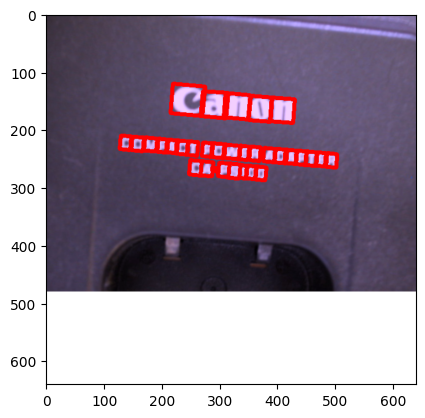

In [16]:
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

In [18]:
detector = keras_ocr.detection.Detector()

batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]
detector.model.fit_generator(
    generator=training_generator,
    steps_per_epoch=math.ceil(len(train) / batch_size),
    epochs=10, #1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_icdar2013.h5'))
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(len(validation) / batch_size)
)

Looking for /root/.keras-ocr/craft_mlt_25k.h5


<ipython-input-18-a2a70544a5fb>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  detector.model.fit_generator(


Epoch 1/10
183/183 [==============================] - 84s 294ms/step - loss: 0.0132 - val_loss: 0.0149
Epoch 2/10
183/183 [==============================] - 51s 281ms/step - loss: 0.0109 - val_loss: 0.0189
Epoch 3/10
183/183 [==============================] - 51s 277ms/step - loss: 0.0101 - val_loss: 0.0084
Epoch 4/10
183/183 [==============================] - 59s 324ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 5/10
183/183 [==============================] - 47s 258ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 6/10
183/183 [==============================] - 49s 268ms/step - loss: 0.0086 - val_loss: 0.0109
Epoch 7/10
183/183 [==============================] - 49s 269ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 8/10
183/183 [==============================] - 49s 265ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 9/10
183/183 [==============================] - 49s 270ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 10/10
183/183 [==============================] - 49s 269ms/step - l

# 실습 - License Plate Detection Data에 맞게 Fine-Tuning하기

1.   get_licenseplate_detector_dataset 라는 licnese plate detection data에 대한 정보를 return하는 함수를 새로 작성 (Reference : https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/datasets.py#L178 )
2.   license plate detector 데이터셋에 맞게 CRAFT 파라미터 Fine-Tuning



# 정보 Return 형태 분석

In [31]:
dataset[0:2]
# image path
# position_vector, string
# 1

[('./icdar2013/Challenge2_Training_Task12_Images/260.jpg',
  [[(array([[ 95, 170],
            [215, 170],
            [215, 309],
            [ 95, 309]]),
     'T'),
    (array([[183, 168],
            [358, 168],
            [358, 309],
            [183, 309]]),
     'A'),
    (array([[367, 166],
            [511, 166],
            [511, 309],
            [367, 309]]),
     'X'),
    (array([[511, 165],
            [554, 165],
            [554, 308],
            [511, 308]]),
     'I')]],
  1),
 ('./icdar2013/Challenge2_Training_Task12_Images/116.jpg',
  [[(array([[ 67, 330],
            [149, 330],
            [149, 408],
            [ 67, 408]]),
     'C'),
    (array([[158, 328],
            [245, 328],
            [245, 408],
            [158, 408]]),
     'O'),
    (array([[248, 330],
            [339, 330],
            [339, 405],
            [248, 405]]),
     'R'),
    (array([[349, 328],
            [441, 328],
            [441, 406],
            [349, 406]]),
     'A'),
  

In [20]:
type(dataset)

list

In [21]:
type(dataset[0])

tuple

In [22]:
dataset[0][1]

[[(array([[ 95, 170],
          [215, 170],
          [215, 309],
          [ 95, 309]]),
   'T'),
  (array([[183, 168],
          [358, 168],
          [358, 309],
          [183, 309]]),
   'A'),
  (array([[367, 166],
          [511, 166],
          [511, 309],
          [367, 309]]),
   'X'),
  (array([[511, 165],
          [554, 165],
          [554, 308],
          [511, 308]]),
   'I')]]

In [23]:
type(dataset[0][1])

list

In [24]:
dataset[0][1][0]

[(array([[ 95, 170],
         [215, 170],
         [215, 309],
         [ 95, 309]]),
  'T'),
 (array([[183, 168],
         [358, 168],
         [358, 309],
         [183, 309]]),
  'A'),
 (array([[367, 166],
         [511, 166],
         [511, 309],
         [367, 309]]),
  'X'),
 (array([[511, 165],
         [554, 165],
         [554, 308],
         [511, 308]]),
  'I')]

In [25]:
type(dataset[0][1][0])

list

In [26]:
dataset[0][1][0][0]

(array([[ 95, 170],
        [215, 170],
        [215, 309],
        [ 95, 309]]),
 'T')

In [27]:
type(dataset[0][1][0][0])

tuple

In [28]:
dataset[0][1][0][0][0]

array([[ 95, 170],
       [215, 170],
       [215, 309],
       [ 95, 309]])

In [29]:
type(dataset[0][1][0][0][0])

numpy.ndarray

In [30]:
dataset[0][1][0][0][0].shape

(4, 2)

# 풀이

In [ ]:
!unzip license_plate_detection_data.zip

In [32]:
import glob
import os
import re

In [45]:
path = '/content/license_plate_detection_data/'
os.listdir(path)
# /content/license_plate_detection_data
# /content/license_plate_detection_data/annotations
# /content/detector_icdar2013.csv

['annotations', 'images']

In [66]:
path = '/content/license_plate_detection_data/annotations/car1.txt'
f = open("/content/license_plate_detection_data/annotations/car1.txt")
tt= f.read()

In [76]:
np.array([nt[0:2], nt[0:2]])

array([['243', '356'],
       ['243', '356']], dtype='<U3')

In [83]:
(np.array([txt_temp[0:2],txt_temp[2:4], txt_temp[4:6],txt_temp[6:8]]),txt_temp[-1])

(array([['243', '356'],
        ['358', '356'],
        ['358', '413'],
        ['243', '413']], dtype='<U3'),
 '"627WWI"')

In [87]:
def get_licenseplate_detector_dataset( file_path ):
    dataset = []

    _txt = os.listdir(f"{path}/annotations")
    _img = os.listdir(f"{path}/images")
    file_size = len(_txt)

    for i in range(file_size):
        txt_path = f"{path}/annotations/{_txt[i]}"
        img_path = f"{path}/images/{_img[i]}"

        f = open(txt_path)
        txt_temp = f.read().split(' ')
        temp = (np.array([txt_temp[0:2],txt_temp[2:4], txt_temp[4:6],txt_temp[6:8]]),txt_temp[-1])

        dataset.append((img_path, temp , 1))

    return dataset

In [88]:
path = '/content/license_plate_detection_data'
get_licenseplate_detector_dataset(path)

[('/content/license_plate_detection_data/images/wts-lg-000136.jpg',
  (array([['356', '330'],
          ['417', '330'],
          ['417', '360'],
          ['356', '360']], dtype='<U3'),
   '"UF2V5S"'),
  1),
 ('/content/license_plate_detection_data/images/c9368c55-210d-456c-a5ef-c310e60039ec.jpg',
  (array([['748', '592'],
          ['829', '592'],
          ['829', '632'],
          ['748', '632']], dtype='<U3'),
   '"TWF220"'),
  1),
 ('/content/license_plate_detection_data/images/car16.jpg',
  (array([['296', '539'],
          ['395', '539'],
          ['395', '588'],
          ['296', '588']], dtype='<U3'),
   '"TRZ951"'),
  1),
 ('/content/license_plate_detection_data/images/wts-lg-000078.jpg',
  (array([['682', '433'],
          ['772', '433'],
          ['772', '478'],
          ['682', '478']], dtype='<U3'),
   '"FB8R4T"'),
  1),
 ('/content/license_plate_detection_data/images/wts-lg-000132.jpg',
  (array([['210', '207'],
          ['302', '207'],
          ['302', '253'],
   

# 답

In [89]:
def get_licenseplate_detector_dataset(cache_dir=None):
  """
  Args:
      cache_dir: The directory in which to store the data.
  Returns:
      Lists of (image_path, lines, confidence) tuples. Confidence
      is always 1 for this dataset. We record confidence to allow
      for future support for weakly supervised cases.
  """
  if cache_dir == None:
    raise ValueError('cache_dir is None')

  main_dir = os.path.join(cache_dir, 'license_plate_detection_data')
  training_images_dir = os.path.join(main_dir, 'images')
  training_gt_dir = os.path.join(main_dir, 'annotations')

  dataset = []
  for gt_filepath in glob.glob(os.path.join(training_gt_dir, '*.txt')):
    image_id = os.path.split(gt_filepath)[1].split('.')[0]
    image_path = os.path.join(training_images_dir, image_id + '.jpg')
    lines = []
    with open(gt_filepath, 'r') as f:
      for row in f.read().split('\n'):
        current_line = []
        row = row.split(' ')
        character = row[-1][1:-1]

        x1, y1, x2, y1, x2, y2, x1, y2 = map(int, row[:8])
        current_line.append((np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]]), character))
        lines.append(current_line)

    # Some lines only have illegible characters and if skip_illegible is True,
    # then these lines will be blank.
    lines = [line for line in lines if line]
    dataset.append((image_path, lines, 1))

  return dataset

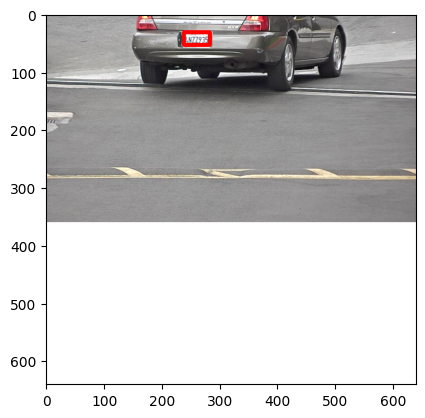

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Epoch 1/3


<ipython-input-92-e23373a19076>:53: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  detector.model.fit_generator(


177/177 [==============================] - 57s 234ms/step - loss: 6.6256e-04 - val_loss: 4.6039e-04
Epoch 2/3
177/177 [==============================] - 40s 226ms/step - loss: 5.8512e-04 - val_loss: 2.3687e-04
Epoch 3/3
177/177 [==============================] - 40s 228ms/step - loss: 5.2639e-04 - val_loss: 3.7667e-04


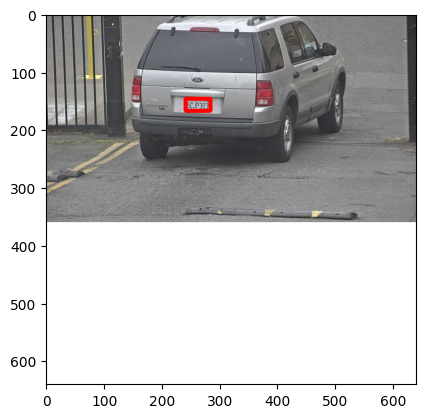

[('./license_plate_detection_data/images/car7.jpg', [[(array([[546, 323],
       [740, 323],
       [740, 420],
       [546, 420]]), '10DTM')]], 1), ('./license_plate_detection_data/images/wts-lg-000012.jpg', [[(array([[571, 283],
       [691, 283],
       [691, 343],
       [571, 343]]), 'CK0A1F')]], 1), ('./license_plate_detection_data/images/wts-lg-000052.jpg', [[(array([[482, 498],
       [550, 498],
       [550, 532],
       [482, 532]]), 'DK7J8G')]], 1), ('./license_plate_detection_data/images/wts-lg-000134.jpg', [[(array([[629, 278],
       [719, 278],
       [719, 323],
       [629, 323]]), '6WAW786')]], 1), ('./license_plate_detection_data/images/21d8c31d-3deb-494b-9c63-c0223306fd82.jpg', [[(array([[698,  85],
       [756,  85],
       [756, 114],
       [698, 114]]), '2DA044')]], 1), ('./license_plate_detection_data/images/wts-lg-000045.jpg', [[(array([[273, 318],
       [352, 318],
       [352, 357],
       [273, 357]]), 'HF4Y3B')]], 1), ('./license_plate_detection_data/imag

FileNotFoundError: ignored

In [92]:
dataset = get_licenseplate_detector_dataset(cache_dir='.')

# train and validation data split
train, validation = sklearn.model_selection.train_test_split(
  dataset, train_size=0.8, random_state=42
)

# set augmenter
augmenter = imgaug.augmenters.Sequential([
  imgaug.augmenters.Affine(
    scale=(1.0, 1.2),
    rotate=(-5, 5)
  ),
  imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
  imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])

# set training and validation generator
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
  labels=train,
  augmenter=augmenter,
  **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
  labels=validation,
  **generator_kwargs
)

# draw one sample training image for sanity check
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)
plt.show()

# set detector and start training
detector = keras_ocr.detection.Detector()
# restore model weights #학습 저장
loading_model_path = os.path.join(data_dir, 'detector_carplate.h5')
if os.path.isfile(loading_model_path) == True:
  detector.model.load_weights(loading_model_path)
  print(loading_model_path + ' model loaded!')

"""## License Plate Detection 데이터에 맞게 Fine-Tuning"""

batch_size = 1
training_generator, validation_generator = [
  detector.get_batch_generator(
    image_generator=image_generator, batch_size=batch_size
  ) for image_generator in
  [training_image_generator, validation_image_generator]
]
detector.model.fit_generator(
  generator=training_generator,
  steps_per_epoch=math.ceil(len(train) / batch_size),
  epochs=3, #1000,
  workers=0,
  callbacks=[
    tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_carplate.csv'), append=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_carplate.h5'))
  ],
  validation_data=validation_generator,
  validation_steps=math.ceil(len(validation) / batch_size)
)

"""# 학습이 끝난 모델 h5 파일 및 트레이닝 로그 다운로드
"""

# from google.colab import files
# files.download("/content/detector_carplate.h5")
#
# files.download("/content/detector_carplate.csv")

"""# Pre-Trained 모델(1000epoch동안 학습시킨 detector_carplate.h5 파일 구글드라이브 링크) : https://drive.google.com/file/d/1hKD1heE0ju3aiXMwcH6ZKEQHSRcOGJ68/view?usp=sharing
"""

# draw one sample training image for sanity check
image, lines, confidence = next(validation_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)
plt.show()


print(validation)

import imageio

output_folder = 'craft_license_plate_validation_result'

for image_path, _, _ in validation:
  image = keras_ocr.tools.read(image_path)

  output_image_path = os.path.join(output_folder, image_path.split('/')[-1])

  # detector prediction
  pred_boxes = detector.detect(np.expand_dims(image, axis=0))

  for each_pred in pred_boxes[0]:
    left, top = each_pred[0]
    right, bottom = each_pred[2]
    canvas = cv2.rectangle(image, (left, top), (right, bottom), (0,255,0), 3)

  imageio.imwrite(output_image_path, canvas)
  print(output_image_path + ' saved!' )